# Matching Algorithm - Matching with Food Description/Name column

There is something wrong with the matching algo. When I run it one i get weird results but when I run it the second time I get better results in some categories 

##### Import Libraries

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re #regular expressions 
from fuzzywuzzy import process, fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

In [22]:
%load_ext watermark

In [25]:
%watermark --iversions

pandas    : 1.5.3
matplotlib: 3.7.1
fuzzywuzzy: 0.18.0
seaborn   : 0.12.2
re        : 2.2.1
numpy     : 1.23.5



##### Read In Data

                                                      M&W Reduced

In [2]:
#pd.set_option('display.max_rows', None)
redFood = pd.read_csv(r"C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\MW_DataReduction\Reduced Total\Updated3_RedLab2021.csv", index_col=0)
redFood.head()

,Food Code,Food Name,Food sub-group codes,Food Group,Sales Format,Normalized Food Name
0,13-145,"ackee, canned, drained",DG,Vegetables,Can,ackeecanneddrained
1,13-146,"agar, dried",DG,Vegetables,Bag,agardried
2,13-148,"alfalfa sprouts, raw",DG,Vegetables,Bagged produce,alfalfasproutsraw
3,14-896,"almonds, whole kernels",GA,Nuts and seeds,Bag,almondswholekernels
4,13-149,"amaranth leaves, raw",DG,Vegetables,Bagged produce,amaranthleavesraw


In [3]:
redFood.describe()

,Food Code,Food Name,Food sub-group codes,Food Group,Sales Format,Normalized Food Name
count,468,511,511,511,401,511
unique,460,508,87,14,72,504
top,17-224,scotch pancakes,DG,Vegetables,packet,biscuitsfullycoatedwithchocolate
freq,2,2,55,107,40,2


In [4]:
redFood.drop(['Normalized Food Name'], axis=1, inplace=True)

Creating a Source column to indicate where I got weight data from

In [5]:
redFood['Source'] = ' '

Remove the word raw from all strings

In [6]:
def clean_composite_name(name):
    replacements = [
        (',', ''),
        (r'\bready to eat\b', ''),
        (r'\bsemi -dried\b', ''),
        (r'\bfresh steamed\b', ''),
        (r'\bboiled flesh and skin\b', ''),
        (r'\bboiled flesh an d skin\b', ''),
        (r'\b flesh and skin boiled\b', ''),
        (r'\braw flesh only\b', ''),
        (r'\bcooked\b', ''),
        (r'\braw\b', ''),
        (r'\bfresh boiled\b', ''),
        (r'\bstewed without sugar\b', ''),
        (r'\bdried\b', ''),
        (r'\bflesh flesh and skin\b', ''),
        (r'\bhomemade\b', ''),
        (r'\bbfresh\b', ''),
        (r'\bboiled\b', ''),
        (r'\braw\b', ''),
        (r'\bdrained\b', ''),
        (r'\bcanned\b', ''),
        (r'\bretial\b', ''),
        (r'\bretail\b', ''),
        (r'\blean\b', ''),
        (r'\bvegetable\b', ''),
        (r'\bplain\b', ''),
    ]
    
    for pattern, replacement in replacements:
        name = re.sub(pattern, replacement, name, flags=re.IGNORECASE)
    
    return name.strip()

# Applying cleaning funtion to DataFrame
redFood['Food Name'] = redFood['Food Name'].apply(clean_composite_name)

In [7]:
pd.set_option('display.max_rows', None)
redFood

,Food Code,Food Name,Food sub-group codes,Food Group,Sales Format,Source
0,13-145,ackee,DG,Vegetables,Can,
1,13-146,agar,DG,Vegetables,Bag,
2,13-148,alfalfa sprouts,DG,Vegetables,Bagged produce,
3,14-896,almonds whole kernels,GA,Nuts and seeds,Bag,
4,13-149,amaranth leaves,DG,Vegetables,Bagged produce,
5,17-851,apple sauce,WC,"Soups, sauces and miscellaneous foods",Prepared food counter,
6,14-016,apples eating,FA,Fruit,Loose produce,
7,14-031,apricots,FA,Fruit,Canned,
9,13-153,artichoke globe,DG,Vegetables,Loose produce,
10,13-157,asparagus,DG,Vegetables,Bunched produce,


                                                         FPS Data

In [8]:
CleanRetai = pd.read_csv(r'C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\FoodPortionSized\FPS_VJ.csv')
CleanRetai['Food Name'] = CleanRetai['Food Name'].str.lower()  # Convert to lowercase
CleanRetai['Food Name'].drop_duplicates(inplace=True)           # Drop duplicate values
CleanRetai['Food Name'].dropna(inplace=True)                   # Drop rows with missing values

Drop if protion consumed had no information

In [9]:
CleanRetai.dropna(subset=['Portion Consumed'], inplace=True)

                            Identify Food Portion Sizes that are equivalent to Retail sold portions

In [10]:
CleanRetail = CleanRetai[CleanRetai['PurEqualCon'].isin(['Y', 'Y, P'])]
CleanRetail.head()#[CleanRetail['Food Name'].str.contains('bread')]#.head()

,Group,Brand,Food Name,Portion Consumed,Weight,PurEqualCon,Purchased,Format,Source
7,BABY FOODS,Cow and Gate,ready to drink baby juice,Stage 1 jars,150g,Y,NaN,NaN,NaN
8,BABY FOODS,Cow and Gate,ready to drink baby juice,Stage 2 jars,200g,Y,NaN,NaN,NaN
11,BABY FOODS,Heinz,fromage frais,Jar,150g,Y,NaN,NaN,NaN
12,BABY FOODS,Heinz,desserts,Can,128g,Y,NaN,NaN,NaN
13,BABY FOODS,Heinz,desserts,Jar,163g,Y,NaN,NaN,NaN


In [11]:
# Applying cleaning funtion to DataFrame
CleanRetail['Food Name'] = CleanRetail['Food Name'].apply(clean_composite_name)

C:\Users\medekar\AppData\Local\Temp\ipykernel_20544\568510896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CleanRetail['Food Name'] = CleanRetail['Food Name'].apply(clean_composite_name)


In [12]:
CleanRetail

,Group,Brand,Food Name,Portion Consumed,Weight,PurEqualCon,Purchased,Format,Source
7,BABY FOODS,Cow and Gate,ready to drink baby juice,Stage 1 jars,150g,Y,NaN,NaN,NaN
8,BABY FOODS,Cow and Gate,ready to drink baby juice,Stage 2 jars,200g,Y,NaN,NaN,NaN
11,BABY FOODS,Heinz,fromage frais,Jar,150g,Y,NaN,NaN,NaN
12,BABY FOODS,Heinz,desserts,Can,128g,Y,NaN,NaN,NaN
13,BABY FOODS,Heinz,desserts,Jar,163g,Y,NaN,NaN,NaN
14,BABY FOODS,Heinz,savoury dishes,Can,128g,Y,NaN,NaN,NaN
15,BABY FOODS,Heinz,savoury dishes,Jar,128g,Y,NaN,NaN,NaN
16,BABY FOODS,Heinz,savoury dishes,Can,163g,Y,NaN,NaN,NaN
17,BABY FOODS,Heinz,savoury dishes,Standard Jar,163g,Y,NaN,NaN,NaN
18,BABY FOODS,Heinz,savoury dishes,Large Jar,200g,Y,NaN,NaN,NaN


###                                                        Match Data (Hybrid Algo).

###### Once matched, Import Weight and Unit Columns into Reduced M&W table

Seem to work better when run twice. Something isn't working well with the matching process

###### Algorithm

In [13]:
%%time

def preprocess_text(df, column_name):
    return df[column_name].str.replace(r'\s+', ' ').str.strip().str.lower()

def fuzzy_matching_score(source, target):
    return fuzz.partial_token_set_ratio(source, target)

def hybrid_fuzzy_matching(CleanRetail, redFood, iterations=2):
    # Set initial and subsequent thresholds for matching
    initial_fuzzy_threshold = 75  # Lower the threshold for initial fuzzy matching
    subsequent_fuzzy_threshold = 95
    cosine_similarity_threshold = 0.80
    min_similarity_threshold = 0.52

    for iteration in range(iterations):
        print(f"Iteration {iteration + 1}/{iterations}")

        # Preprocess text data in both DataFrames for the "Merged Name" field.
        CleanRetail['Food Name'] = preprocess_text(CleanRetail, 'Food Name')
        redFood['Food Name'] = preprocess_text(redFood, 'Food Name')

        # Step 1: Fuzzy Matching (Initial: permissive, Subsequent: stricter)
        if iteration == 0:
            partial_token_set_ratio_threshold = initial_fuzzy_threshold
        else:
            partial_token_set_ratio_threshold = subsequent_fuzzy_threshold

        CleanRetail['Partial Token Set Ratio'] = CleanRetail['Food Name'].apply(
            lambda x: fuzzy_matching_score(x, redFood['Food Name']))
        potential_matches = CleanRetail[CleanRetail['Partial Token Set Ratio'] >= partial_token_set_ratio_threshold]

        # Step 2: TF-IDF and Cosine Similarity (Text Matching)
        vectorizer = TfidfVectorizer()
        combined_texts = potential_matches['Food Name'].append(redFood['Food Name'])
        tfidf_combined = vectorizer.fit_transform(combined_texts)

        tfidf_clean_retail = tfidf_combined[:potential_matches.shape[0]]
        tfidf_red_food = tfidf_combined[potential_matches.shape[0]:]

        similarities = pairwise_distances(tfidf_red_food, tfidf_clean_retail, metric='cosine')
        max_sim_indices = similarities.argmin(axis=1)
        max_sim_scores = 1 - similarities.min(axis=1)  # Convert cosine distance to similarity

        # Update redFood DataFrame with matched information and sources
        redFood['Similarity Score'] = max_sim_scores
        redFood['Weight'] = potential_matches['Weight'].values[max_sim_indices]
        redFood['PurEqualCon'] = potential_matches['PurEqualCon'].values[max_sim_indices]
        redFood['Portion Consumed'] = potential_matches['Portion Consumed'].values[max_sim_indices]

        # Create a mapping dictionary for matched indices to their sources
        match_indices_to_sources = dict(zip(potential_matches.index, potential_matches['Source']))

        # Map the sources and format to the redFood DataFrame based on matched indices
        redFood['Source'] = redFood.index.map(lambda i: match_indices_to_sources.get(i, ''))

        # Set to NaN for rows where similarity score is below the minimum threshold
        redFood.loc[redFood['Similarity Score'] < min_similarity_threshold,
                    ['Weight', 'PurEqualCon', 'Portion Consumed', 'Source']] = ''

        # Update CleanRetail with new matches from redFood
        CleanRetail = CleanRetail.append(redFood[redFood['Similarity Score'] >= min_similarity_threshold])

    return redFood

# Call the hybrid_fuzzy_matching function with iterations and get the matched DataFrame
redFood_matched = hybrid_fuzzy_matching(CleanRetail.copy(), redFood.copy(), iterations=2)

Iteration 1/2


<timed exec>:2: FutureWarning: The default value of regex will change from True to False in a future version.
<timed exec>:33: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:2: FutureWarning: The default value of regex will change from True to False in a future version.


Iteration 2/2
CPU times: total: 4.8 s
Wall time: 5.13 s


<timed exec>:33: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Identifying Matched Items with weights

In [14]:
d = redFood_matched.loc[redFood_matched['Weight'] != '']
d['Food Name'].value_counts().sum()

97

In [17]:
redFood_matched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511 entries, 0 to 590
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Food Code             468 non-null    object 
 1   Food Name             511 non-null    object 
 2   Food sub-group codes  511 non-null    object 
 3   Food Group            511 non-null    object 
 4   Sales Format          401 non-null    object 
 5   Source                500 non-null    object 
 6   Similarity Score      511 non-null    float64
 7   Weight                511 non-null    object 
 8   PurEqualCon           511 non-null    object 
 9   Portion Consumed      511 non-null    object 
dtypes: float64(1), object(9)
memory usage: 43.9+ KB


#### Export Matched DataSet

In [16]:
#redFood_matched.to_csv(r'C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\ReducedwithWeights\matchedwithFPS.csv')

### 320 / 535 items Matched Using Algo 4 which is a combination of Algo 2 & It uses the fuzz.partial_token_set_ratio & Term Frequency-Inverse Document Frequency

In [18]:
f'Fourth Algorithm Matched {round((97/511) * 100, 2)}% of products between McCane and Widdowson df and Food Portion Sizes df at a threshold of 90 and a Cosine threshold of 70. Contains some errors'

'Fourth Algorithm Matched 18.98% of products between McCane and Widdowson df and Food Portion Sizes df at a threshold of 90 and a Cosine threshold of 70. Contains some errors'

## Plotting Matching Efficiency of Algo 4

Find total counts of food by Super Group

In [20]:
d = redFood_matched[redFood_matched['Weight'] != '']
ax4_s = d.groupby('Food Group')['Food Name'].count().rename('Matched Prod Count', inplace=True).copy().sort_values(ascending=True)
ax4 = pd.DataFrame(ax4_s).reset_index()
ax4

,Food Group,Matched Prod Count
0,Fats and oils,2
1,Alcoholic beverages,3
2,Herbs and spices,3
3,Beverages,4
4,Milk and milk products,4
5,Fruit,6
6,Nuts and seeds,6
7,Fish and fish products,7
8,Meat and meat products,7
9,"Soups, sauces and miscellaneous foods",9


In [21]:
ax4_count = redFood_matched.groupby('Food Group')['Food Name'].count().rename('Total Prod Count', inplace=True).copy().sort_values(ascending=True)
ax4_nt = pd.DataFrame(ax4_count).reset_index()
ax4_nt

,Food Group,Total Prod Count
0,Eggs,1
1,Alcoholic beverages,8
2,Fats and oils,10
3,Beverages,12
4,Nuts and seeds,20
5,Fish and fish products,21
6,"Sugars, preserves and snacks",24
7,Herbs and spices,30
8,Milk and milk products,38
9,"Soups, sauces and miscellaneous foods",40


In [22]:
# Evaluating Percentaged Mapped
ax4_counts = ax4_nt.merge(ax4, on='Food Group', how='left')
ax4_counts['%Matched'] = ax4_counts['Matched Prod Count'] / ax4_counts['Total Prod Count'] * 100 

C:\Users\medekar\AppData\Local\Temp\ipykernel_22048\1404641568.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=12)


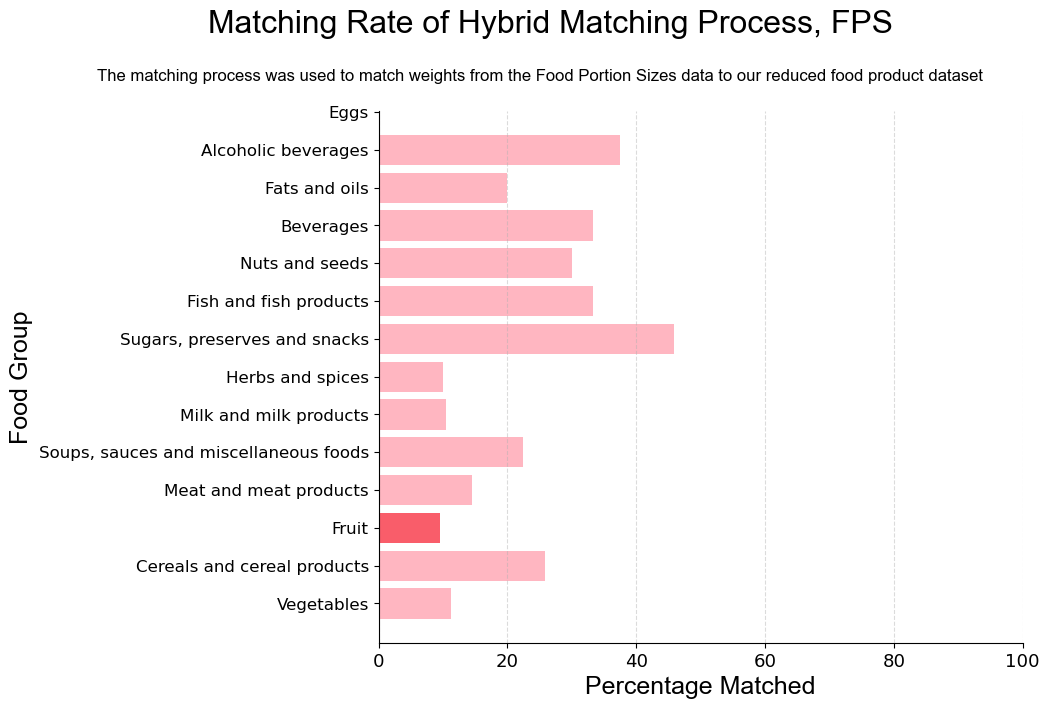

In [23]:
import matplotlib.font_manager as fm

# Find the minimum count in the ax4_counts DataFrame.
min_count4 = ax4_counts['%Matched'].min()

# Create a custom color palette.
bar_colors4 = ['lightpink' if count != min_count4 else '#f95d6a' for count in ax4_counts['%Matched']]

# Set the font family and size for the title.
title_font = fm.FontProperties(family='Arial', size=23)
subtitle_font = fm.FontProperties(family='Arial', size=12)

# Set the font family and size for the axes labels.
axis_font = fm.FontProperties(family='Arial', size=18)

# Create the figure and axes objects.
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the horizontal bar chart.
bars = ax.barh(ax4_counts['Food Group'], ax4_counts['%Matched'], color=bar_colors4)

# Add gridlines to the plot.
ax.grid(axis='x', linestyle='--', alpha=0.45)

# Customize the title, x-axis, and y-axis labels.
plt.suptitle('Matching Rate of Hybrid Matching Process, FPS',ha='center', fontproperties=title_font, y=1)  # Add y parameter
ax.set_title('The matching process was used to match weights from the Food Portion Sizes data to our reduced food product dataset', ha='center', fontproperties=subtitle_font, y=1.04, x=0.25)  # Add y parameter for subtitle
ax.set_xlabel('Percentage Matched', fontproperties=axis_font)
ax.set_ylabel('Food Group', fontproperties=axis_font)

# Set the maximum value of the x-axis to 100.
ax.set_xlim(0, 100)

# Adjust the spacing around the plot.
plt.tight_layout(pad=1.07)

# Remove the top and right spines from the plot.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Increase the tick label font size.
ax.tick_params(axis='x', which='major', labelsize=13)

# Adjust y-axis tick label alignment and font size.
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=12)

# Invert the y-axis to display the lowest match on top.
ax.invert_yaxis()

    # Show the plot.
plt.show()


                                                  NEXT NOTEBOOK